In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
#RUN

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from torchvision import models
from torch.optim import lr_scheduler
#from tensorboard_logger import configure, log_value
import time

In [0]:
#Incarc imaginile cu tumori si ground-truth din drive
#Read the images and ground_truth from drive

#RUN
Fold_1 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_1.mat')
Fold_2 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_2.mat')
Fold_3 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_3.mat')
Fold_4 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_4.mat')
Fold_5 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_5.mat')

fold_1 = Fold_1['Fold_1']
fold_2 = Fold_2['Fold_2']
fold_3 = Fold_3['Fold_3']
fold_4 = Fold_4['Fold_4']
fold_5 = Fold_5['Fold_5']


In [0]:

#RUN
def get_5_fold(index_4, index_1):
    x = [None]*5
    y = [None]*5
    t = [None]*5
    x[0] = fold_1[:,0]
    x[1] = fold_2[:,0]
    x[2] = fold_3[:,0]
    x[3] = fold_4[:,0]
    x[4] = fold_5[:,0]

    y[0] = fold_1[:,1:(512*512)+ 1]
    y[1] = fold_2[:,1:(512*512)+ 1]
    y[2] = fold_3[:,1:(512*512)+ 1]
    y[3] = fold_4[:,1:(512*512)+ 1]
    y[4] = fold_5[:,1:(512*512)+ 1]

    t[0] = fold_1[:,(512*512)+ 1:2*(512*512)+ 1]
    t[1] = fold_2[:,(512*512)+ 1:2*(512*512)+ 1]
    t[2] = fold_3[:,(512*512)+ 1:2*(512*512)+ 1]
    t[3] = fold_4[:,(512*512)+ 1:2*(512*512)+ 1]
    t[4] = fold_5[:,(512*512)+ 1:2*(512*512)+ 1]

    labels_train = np.concatenate([x[index_4[0]], x[index_4[1]], x[index_4[2]], x[index_4[3]]], 0)
    images_train = np.concatenate([y[index_4[0]], y[index_4[1]], y[index_4[2]], y[index_4[3]]], 0)
    masks_train = np.concatenate([t[index_4[0]], t[index_4[1]], t[index_4[2]], t[index_4[3]]], 0)

    labels_test = x[index_1[0]]
    images_test = y[index_1[0]]
    masks_test = t[index_1[0]]
    del x,y,t
    return labels_train, images_train, masks_train, labels_test, images_test, masks_test

In [0]:
#RUN

# Realize 5-fold cross-validation
from itertools import combinations 
  
# Get all combinations of [1, 2, 3, 4, 5] 
# and length 4
comb = combinations([0, 1, 2, 3, 4], 4) 
comb = list(comb)
#Choose a combination from 0..4
ind = 0
res = [ele  for ele in range(5) if ele   not in comb[ind]] 

#Print first 4-fold indexex for train, and 1-fold index for test
print('Indexes for train: ', comb[ind])
print('Index for test', res)

labels_train, images_train, masks_train, labels_test, images_test, masks_test = get_5_fold(comb[ind], res)
#depend on batch_size


Indexes for train:  (0, 1, 2, 3)
Index for test [4]


In [0]:
print(labels_train.shape, labels_test.shape)
print(ind)

(2406,) (643,)
0


In [0]:
#RUN
# Choose l1 and l2 depending on batch_size, and 5_fold generation
# batch should divide de size
# Here I hard coded the values for train and test, depending on folders that I have selected for train and test
l = [[2400, 630], [2430, 600], [2460, 570], [2370, 630], [2490, 540]]
l1 = [[1650, 450]]

CHOOSE = l

size_train_loader = CHOOSE[ind][0]
size_test_loader = CHOOSE[ind][1]

labels_train = labels_train[0:size_train_loader]
images_train = images_train[0:size_train_loader, :]
masks_train = masks_train[0:size_train_loader, :]

labels_test = labels_test[0:size_test_loader]
images_test = images_test[0:size_test_loader, :]
masks_test = masks_test[0:size_test_loader, :]

print(labels_train.shape, images_train.shape, masks_train.shape)
print(labels_test.shape, images_test.shape, masks_test.shape)



(2400,) (2400, 262144) (2400, 262144)
(630,) (630, 262144) (630, 262144)


In [0]:
#RUN to permute data
from sklearn.utils import shuffle

shuffle_labels_train, shuffle_images_train, shuffle_mask_train = shuffle(labels_train, images_train, masks_train, random_state=0)
shuffle_labels_test, shuffle_images_test, shuffle_mask_test = shuffle(labels_test, images_test, masks_test, random_state=0)



In [0]:
print(shuffle_labels_train.shape, shuffle_images_train.shape, shuffle_mask_train.shape)


(2400,) (2400, 262144) (2400, 262144)


In [0]:
#RUN
#free RAM, because session will crash
%reset_selective -f Fold_1
%reset_selective -f Fold_2
%reset_selective -f Fold_3
%reset_selective -f Fold_4
%reset_selective -f Fold_5

%reset_selective -f fold_1
%reset_selective -f fold_2
%reset_selective -f fold_3
%reset_selective -f fold_4
%reset_selective -f fold_5



In [0]:
unique, counts = np.unique(shuffle_labels_train, return_counts=True)
uniquee, countss = np.unique(shuffle_labels_test, return_counts=True)

print(counts, countss)


[ 542 1133  725] [165 275 190]


In [0]:
shuffle_labels_train = torch.from_numpy(shuffle_labels_train)
shuffle_images_train = torch.from_numpy(shuffle_images_train)
shuffle_mask_train = torch.from_numpy(shuffle_mask_train)

shuffle_labels_test = torch.from_numpy(shuffle_labels_test)
shuffle_images_test = torch.from_numpy(shuffle_images_test)
shuffle_mask_test = torch.from_numpy(shuffle_mask_test)

In [0]:
mean_tr = (shuffle_images_train.float().mean())
std_tr = (shuffle_images_train.float().std())
print(mean_tr, std_tr)

tensor(457.7594) tensor(644.9455)


In [0]:
class BrainDataset(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_y, ratio, size, transform=None):
        self.X = t_x
        self.Y = t_y
        self.ratio = ratio
        self.size = size
        self.transform = transform
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image):#, mask):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        #mask = transforms.ToPILImage()(mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            #mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            #mask = TF.vflip(mask)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)
            #mask = TF.rotate(mask, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)
        return image#, mask

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        #label = label.view(-1, 512)
        #label = label[0:512:self.ratio,0:512:self.ratio]
        
        item = item.float()
        item = (item - mean_tr)/std_tr
        
        if self.transform == 1:   
          item = self.transformm(np.float32(item.view(-1, self.size)))#, np.float32(label.view(-1, self.size)))
        else:
          #label = transforms.ToPILImage()(np.float32(label.view(-1, self.size)))
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          #label = TF.to_tensor(label)
          item = TF.to_tensor(item)
        return (item, label)

In [0]:
#RUN
batch_size = 30
ratio = 2 #how much we reduce from 1 dimension of image. Ex. ratio = 2 => 256x256 image , ratio = 4 => 512x512
size_image = 256 #Dimmension by dividing height and weight to ratio

train_dataset = BrainDataset(shuffle_images_train, shuffle_labels_train, ratio, size_image, transform = 1)
test_dataset = BrainDataset(shuffle_images_test,shuffle_labels_test, ratio, size_image, transform = 0)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           );
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          );
##########




torch.Size([1, 256, 256])
tensor(2, dtype=torch.int16)


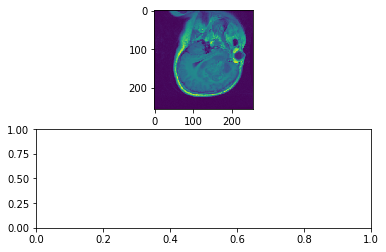

630


In [0]:
#RUN to test if data is normalized, and mask is correlated with image
#Printez sa vad daca s-a normalizat
#Print values from an image to see if values are normalized

t, l = train_dataset.__getitem__(0)
#print(t[0][100])
print(t.shape)
print(l)

plt.figure(1)
plt.subplot(211)
plt.imshow(t[0])

plt.subplot(212)
#plt.imshow(l[0])
plt.show()
print(test_dataset.__len__())

In [0]:
labels_map = {1 : 'Meningioma', 2 : 'Glioma', 3 : 'Pituitary Tumor'};

fig = plt.figure(figsize=(10,10));
columns = 3;
rows = 3;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(data_x));
    img = data_x[img_xy,:]
    img = torch.Tensor.cpu(img).detach()
    img = img.reshape(-1,512)    
    fig.add_subplot(rows, columns, i)
    l = data_y[img_xy]
    l =  int(torch.Tensor.cpu(l).detach().numpy())
    plt.title(labels_map[l])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [0]:
labels_map = {1 : 'Meningioma', 2 : 'Glioma', 3 : 'Pituitary Tumor'};
labels_map = ['Meningioma', 'Glioma', 'Pituitary Tumor' ]
input_size = 65536
num_classes = 3
batch_size = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
lr = 0.0001
num_epochs = 3

cuda:0


In [0]:
# RUN => Model feedforward
net_feed = Net(input_size, hidden_size, num_classes)
net_feed = net_feed.to(device)

In [0]:
print(net_resnet)

In [0]:
# RUN => model Resnet
net_resnet = models.resnet101(pretrained=True)

#I recommend training with these layers unfrozen for a couple of epochs after the initial frozen training
for param in net_resnet.parameters():
    param.requires_grad = False

net_resnet.fc = nn.Linear(2048, num_classes)
net_resnet.to(device)

In [0]:
#Choose the model to train
model = net_resnet
nume_model = 'resnet101_.pt'
typee = 'resnet' #|| resnet or feed


In [0]:
#choose hyperparameters
lr = 0.0001
num_epochs = 2
criterion = nn.CrossEntropyLoss()
#optimiser = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=5e-4)
optimiser = torch.optim.SGD(model.parameters(), lr=lr)       #SGD opti4Zser
scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.75, patience=5, verbose=True)



In [0]:
torch.cuda.empty_cache()
print(optimiser)
print(criterion)
acc = 0


In [0]:
path_save = 'gdrive/My Drive/Licenta/T/ResNet_clasif/' + nume_model
torch.save(model.state_dict(),path_save)


In [0]:
path_load = 'gdrive/My Drive/Licenta/T/ResNet_clasif/' + 'resnet_101.pt'
model.load_state_dict(torch.load(path_load))


In [0]:
#Lists to save plots
test_losses = []
train_losses = []
accuracy = []
loss_valid = 0.2872


In [0]:

def validate():
      correct = 0
      total = 0
      val_loss = 0
      model.eval()
      print('--------------TEST--------------')
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
          labels = labels.to(device).long() - 1
          
          if typee == 'feed':
            images = images.view(1, -1)
          else:
            images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
            images = images.to(device).float()
            
          with torch.no_grad():
            outputs = model(images)
          loss = criterion(outputs, labels)
          loss_data = loss.data.item()
            
          if np.isnan(loss_data):
              raise ValueError('loss is nan while validating')

          val_loss += loss
          if i%50 == 0:
              print ("iter {}, loss: {}".format( i, loss))

          _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
          
          #print(predicted)
          #print(outputs.data)
          
          total += labels.size(0)                    # Increment the total count
          correct += (predicted == labels).sum()     # Increment the correct count
          
          del images
          del labels
          del loss
          del outputs
          torch.cuda.empty_cache()

      print(val_loss/((i+1)))
      test_losses.append(val_loss/((i+1)))
      accuracy.append((100 * correct / total))
      print('Accuracy of the network on test_loader', (100 * correct.detach().cpu().data.item() / total))
      print('Corect: ', correct.detach().cpu().data.item())
      print('Total: ', total)
      print('--------------TEST--------------')
      return (100 * correct / total), (val_loss/((i+1)))

In [0]:
#Training script

num_epochs = 5
for epoch in range(num_epochs):
    train_l = 0
    ts = time.time()
    model.train()
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = labels.to(device).long() - 1
        
        if typee == 'feed':
          images = images.view(batch_size, -1)
        else:
          images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
          images = images.to(device).float()
        
        optimiser.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = model(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
       
        
        loss.backward()                                   # Backward pass: compute the weight
        optimiser.step()                                  # Optimizer: update the weights of hidden nodes
        train_l += loss
          
        if (i) % 50 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, i, len(train_dataset)//batch_size, loss))
        del images
        del labels
        del loss
        del outputs
        torch.cuda.empty_cache()

    print(train_l/(i+1))
    train_losses.append(train_l/(i+1))
    print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
    print('--------------END EPOCH--------------')
    mean_loss = (train_l/(i+1))
    ac,loss_v = validate()
    scheduler.step(loss_v)
    
    if loss_v < loss_valid:
          print("Save model:", ac)
          loss_valid = loss_v
          torch.save(model.state_dict(),path_save)

    #validatee()

      

In [0]:
from matplotlib import pyplot

def plot_loss(loss, label, name, xlabel, ylabel, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.legend()
    pyplot.savefig(name)
def save_plot(loss, label, name, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
    pyplot.savefig(name)
nume = 'resnet152.png'
def plot_loss_t_t(loss1, loss2, label1, label2, name, color1='blue', color2='red'):
    pyplot.plot(loss1, label=label1, color=color1)
    pyplot.plot(loss2, label=label2, color=color2)
    pyplot.xlabel("Epoca")
    pyplot.ylabel("Eroare")
    pyplot.legend()
    pyplot.savefig(name)

In [0]:

plot_loss_t_t(train_losses, test_losses, 'train_loss', 'test_loss', '/content/gdrive/My Drive/Licenta/FeedForward/train_test_loss' + nume,'red', 'blue')

In [0]:
plot_loss(accuracy, 'Acuratete', '/content/gdrive/My Drive/Licenta/FeedForward/mean_iou_' + nume,  'Epoca', 'Acuratete', 'red')

In [0]:
#Function to plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

def plot_bar_chart(x, classes):
  fig, ax = plt.subplots()
  
  ax.bar(x, height= [1,2,3]) 
  ax.set(xticklabels = classes)
  fig.tight_layout()
  return 

In [0]:
#Function to get all segmentation from test dataset, to calculate precion, recall, f1-score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, precision_recall_fscore_support

pred = torch.empty(30)
lab = torch.empty(30)
matrix_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=30,
                                          );
for i, (images, labels) in enumerate(test_loader):
          images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
          labels = labels.to(device).long() - 1
          
          if typee == 'feed':
            images = images.view(batch_size, -1)
          else:
            images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
            images = images.to(device).float()
          
          outputs = model(images)
          #if i%50 == 0:
           #   print ("iter {}, loss: {}".format( i, loss))

          _, predicted = torch.max(outputs.data, 1) 
          pred = torch.cat((pred, predicted.cpu().float()), 0)
          lab = torch.cat((lab, labels.cpu().float()), 0)
lab = lab[30:lab.shape[0]]
pred = pred[30:pred.shape[0]]

In [0]:
conf_matrix = confusion_matrix(lab.cpu().numpy(), pred.cpu().numpy())
print('==================')
print(conf_matrix)
print('==================')


TP = conf_matrix.diagonal()
for c in range(num_classes):
  idx = torch.ones(num_classes).byte()
  idx[c] = 0
  TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
  FP = conf_matrix[c, idx].sum()
  FN = conf_matrix[idx, c].sum()
  sensitivity = (TP[c] / (TP[c]+FN))
  specificity = (TN / (TN+FP))
  
  print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
      c, TP[c], TN, FP, FN))
  print('Sensitivity = {}'.format(sensitivity))
  print('Specificity = {}'.format(specificity))
  print('==================')


In [0]:
print ('Accuracy:', accuracy_score(lab.cpu().numpy(), pred.cpu().numpy()))
print ('Recall:', recall_score(lab.cpu().numpy(), pred.cpu().numpy(), average='macro'))
print ('Precision:', precision_score(lab.cpu().numpy(), pred.cpu().numpy(), average='macro'))

print ('F1 score:', f1_score(lab.cpu().numpy(), pred.cpu().numpy(), average='macro'))
print(precision_recall_fscore_support(lab.cpu().numpy(), pred.cpu().numpy(), average='macro'))

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(lab.cpu().numpy(), pred.cpu().numpy(), classes=labels_map,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(lab.cpu().numpy(), pred.cpu().numpy(), classes=labels_map, normalize=True,
                      title='Normalized confusion matrix')
unique, counts = np.unique(labels.cpu().numpy(), return_counts=True)
plt.savefig('/content/gdrive/My Drive/Licenta/VGG_balanced/matrix' + nume)
plt.show()


In [0]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(labels_map))
    plt.tight_layout()
    plt.bar(index, counts)
    plt.xlabel('Types', fontsize=10)
    plt.ylabel('No of samples', fontsize=10)
    plt.xticks(index, labels_map, fontsize=10, rotation=30)
    plt.title('Tumors number')
    plt.savefig('/content/gdrive/My Drive/Licenta/FeedForward/numbers_' + nume, dpi = 100, bbox_inches='tight')
    plt.show()
plot_bar_x()

In [0]:
def validatee():
      correct = 0
      total = 0
      val_loss = 0
      model.eval()
      print('--------------TEST--------------')
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
          labels = labels.to(device).long() - 1
          
          if typee == 'feed':
            images = images.view(batch_size, -1)
          else:
            images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
            images = images.to(device).float()
          
          outputs = model(images)
          #if i%50 == 0:
           #   print ("iter {}, loss: {}".format( i, loss))

          _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
          
          #print(predicted)
          #print(outputs.data)
          
          total += labels.size(0)                    # Increment the total count
          correct += (predicted == labels).sum()     # Increment the correct count
          del images
          del labels
          torch.cuda.empty_cache()

      print('Accuracy of the network on the 1,5k train images: %d %%' % (100 * correct / total))
      print('--------------TEST--------------')


In [0]:
def plot_loss_t_t_t(loss1, loss2, loss3, label1, label2, label3, name, color1='blue', color2='red', color3='green'):
    pyplot.plot(loss1, label=label1, color=color1)
    pyplot.plot(loss2, label=label2, color=color2)
    pyplot.plot(loss3, label=label3, color=color3)
    pyplot.xlabel("Epoca")
    pyplot.ylabel("Acuratete")
    pyplot.legend()
    pyplot.savefig(name)